In [1]:
import sys
sys.path.append('/Data/reds_dataset/6.8300-Computer-Vision/src')
from time import time
from models import basicVSR

from torchvision.io import read_image
from torchvision.utils import flow_to_image
from data_handlers.loading import VideoDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models.optical_flow import raft

from models.basicVSR.SPyNet import SPyNet

import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def get_spynet(pretrained):
        model=SPyNet()
        if pretrained:
            model_p=model.state_dict()
            pre_p=torch.load(pretrained)
            ppl=list(pre_p)
            for i,k in enumerate(model_p.keys()):
                if i<2:
                    continue
                model_p[k]=pre_p[ppl[i-2]]
            model.load_state_dict(model_p)
        return model



In [3]:
model_init = basicVSR(spynet_pretrained='../checkpoints/spynet_20210409-c6c1bd09.pth', pretrained_model = 'False')
model_pret = basicVSR(spynet_pretrained='../checkpoints/spynet_20210409-c6c1bd09.pth', pretrained_model='../checkpoints/basicvsr.pth')


In [4]:
test_dataset = VideoDataset(
        lr_data_dir='../data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='../data/processed/train/train_sharp',
        rolling_window=3,
        is_test=True,
        is_small_test=True,
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion_mse = nn.MSELoss().to(device)

model_init = model_init.to(device)
model_pret = model_pret.to(device)

model_init.is_mirror_extended = False
model_pret.is_mirror_extended = False

In [5]:
loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [8]:
model_raft = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)


model_raft = model_raft.eval()

### Try to exec flow with RAFT

In [9]:
lq, gt = next(iter(loader))

lq = lq.to(device)
gt = gt.to(device)

# offset lq by 1 frame
lq_base = lq[:, 0, :, :, :].clone()
lq = lq[:, 1, :, :, :]

# resize to 176*320
lq = nn.functional.interpolate(lq, size=(176, 320), mode='bilinear', align_corners=False)
lq_base = nn.functional.interpolate(lq_base, size=(176, 320), mode='bilinear', align_corners=False)

flows = model_raft(lq, lq_base)

In [17]:
flows[-1].shape

torch.Size([20, 2, 176, 320])

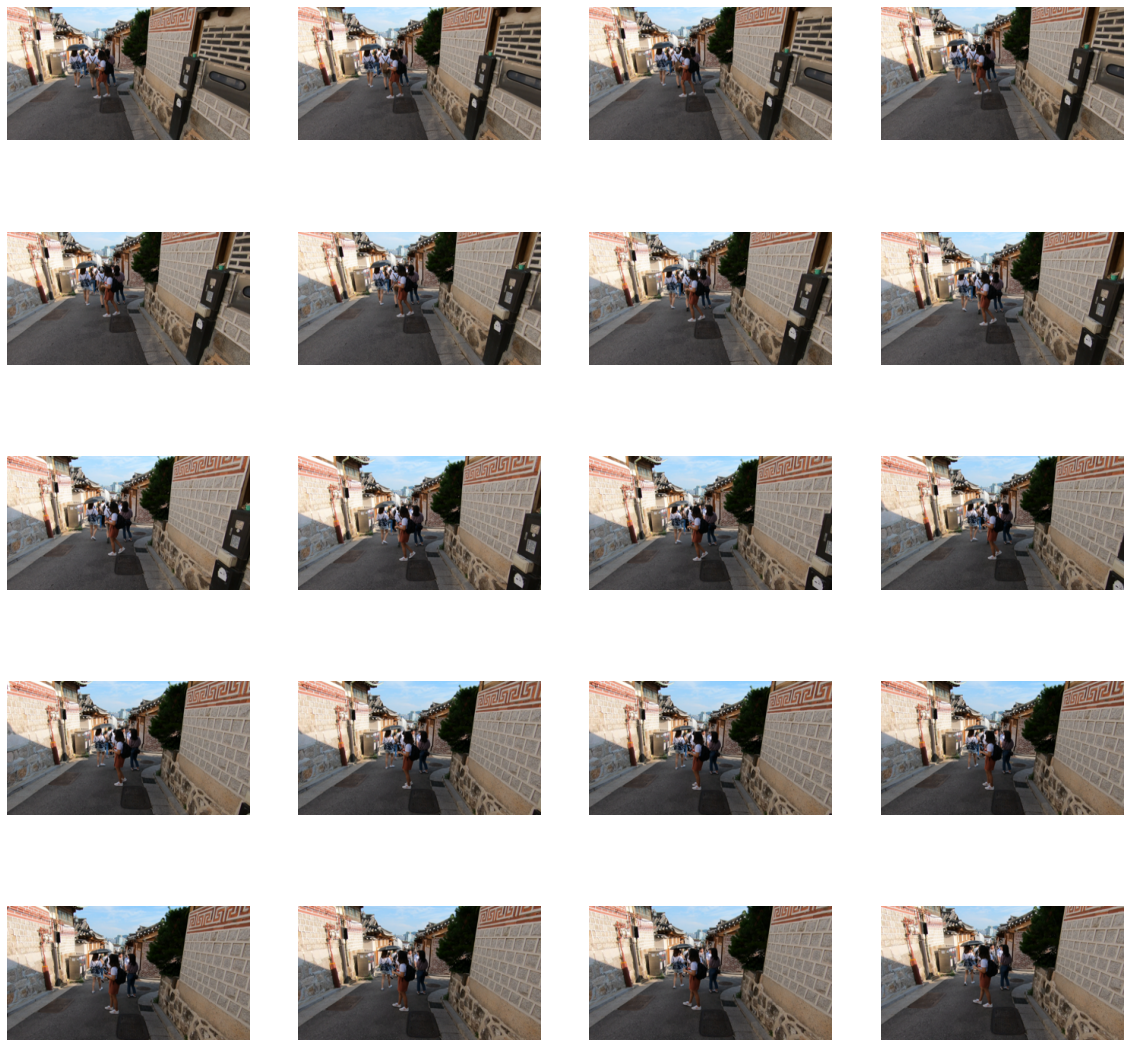

In [19]:
fig, ax = plt.subplots(5,4, figsize=(20,20))
for i in range(5):
    for j in range(4):
        img = lq[i*4+j].permute(1,2,0).cpu().detach().numpy()
        ax[i][j].imshow(img)
        ax[i][j].axis('off')

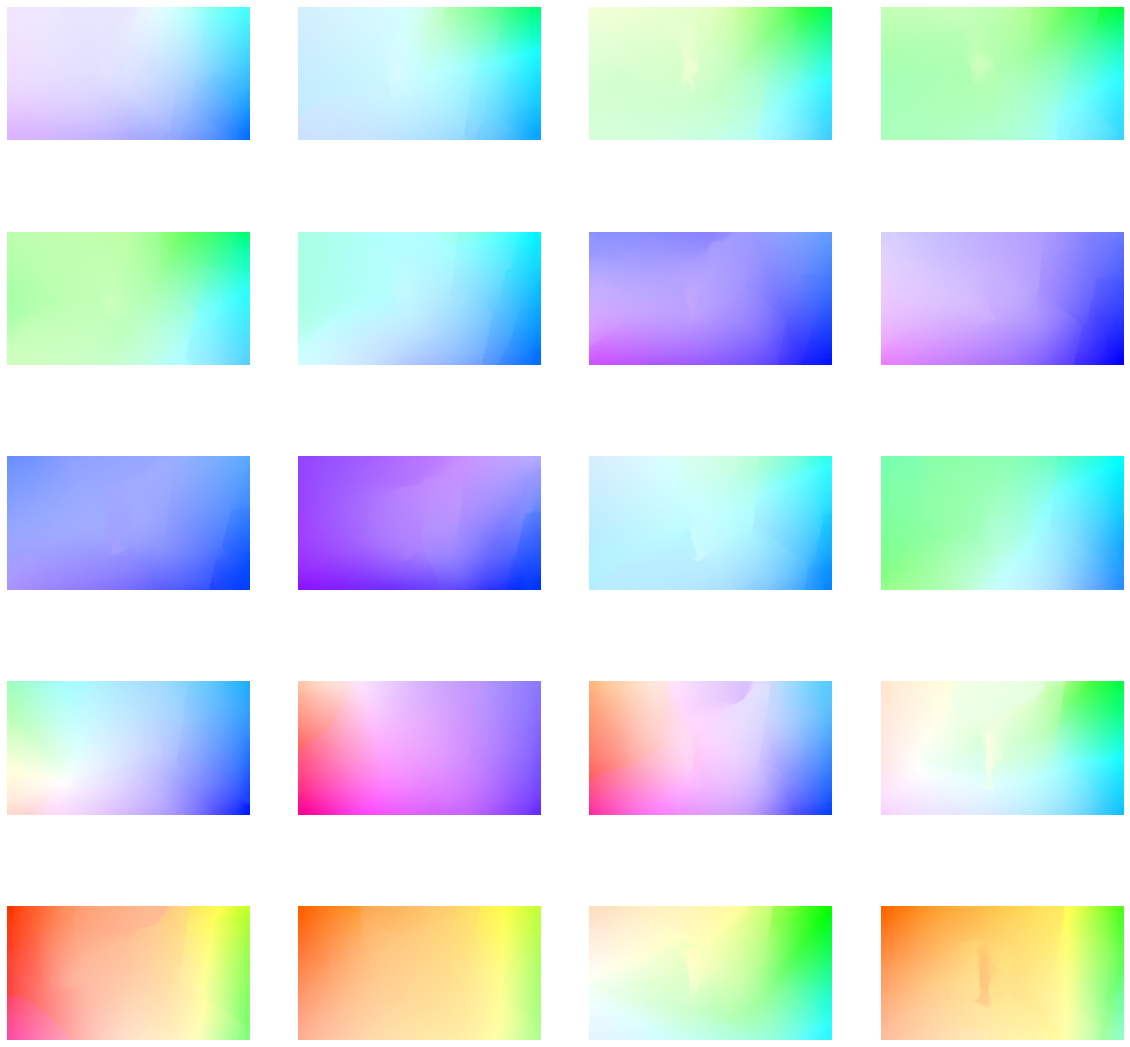

In [18]:
# print the flow

fig, ax = plt.subplots(5,4, figsize=(20,20))
for i in range(5):
    for j in range(4):
        flow = flows[-1][i*4+j, :, :, :].detach().cpu()
        ax[i][j].imshow(flow_to_image(flow).permute(1,2,0))
        ax[i][j].axis('off')

# Compare optical flow from our model

In [21]:
def flow_to_color(predicted_flows):
    flow_imgs = flow_to_image(predicted_flows)

    # The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
    # enhance the flow
    
    return flow_imgs.permute(1, 2, 0)

In [22]:
# print the images for the lq and the mdel init
lq, gt = next(iter(loader))

lq = lq.to(device)
gt = gt.to(device)

flow_fwd, flow_bwd = model_init.compute_flow(lq)

# display flow_fwd as an image
# display flow_bwd as an image

# print the images for the lq and the mdel pret
flow_fwd_pret, flow_bwd_pret = model_pret.compute_flow(lq)


fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# on the first row, display the 3 images of the lq
axs[0, 0].imshow(lq[0, 0, :, :].permute(1, 2, 0).cpu().detach().numpy())
axs[0, 1].imshow(lq[0, 1, :, :].permute(1, 2, 0).cpu().detach().numpy())
axs[0, 2].imshow(lq[0, 2, :, :].permute(1, 2, 0).cpu().detach().numpy())

#second row, plot the flow_fwd
axs[1,1].imshow(flow_to_color(flow_fwd[0, 0, :, :].cpu().detach()))
axs[1,2].imshow(flow_to_color(flow_fwd[0, 1, :, :].cpu().detach()))

# third row, plot the flow_bwd
axs[2,1].imshow(flow_to_color(flow_bwd[0, 0, :, :].cpu().detach()))
axs[2,0].imshow(flow_to_color(flow_bwd[0, 1, :, :].cpu().detach()))

# fourth row, plot the flow_fwd_pret
axs[3,1].imshow(flow_to_color(flow_fwd_pret[0, 0, :, :].cpu().detach()))
axs[3,2].imshow(flow_to_color(flow_fwd_pret[0, 1, :, :].cpu().detach()))

# fifth row, plot the flow_bwd_pret
axs[4,1].imshow(flow_to_color(flow_bwd_pret[0, 0, :, :].cpu().detach()))
axs[4,0].imshow(flow_to_color(flow_bwd_pret[0, 1, :, :].cpu().detach()))


OutOfMemoryError: CUDA out of memory. Tried to allocate 600.00 MiB (GPU 0; 23.67 GiB total capacity; 20.56 GiB already allocated; 277.50 MiB free; 22.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [56]:
# calculate the psnr between the flows of the init model and the pret model
psnr_fwd = 10 * torch.log10(1 / criterion_mse(flow_fwd, flow_fwd_pret))
psnr_bwd = 10 * torch.log10(1 / criterion_mse(flow_bwd, flow_bwd_pret))

print(psnr_fwd)
print(psnr_bwd)

tensor(19.3421, device='cuda:0', grad_fn=<MulBackward0>)
tensor(13.8750, device='cuda:0', grad_fn=<MulBackward0>)
